## Obtaining streetview via selenium scraper

In [41]:
# Load dependencies and env vars
%load_ext autoreload
%autoreload 2

import json
import math
import os
import random

from utils.ui import loader, plot_dataset, plot_point_and_class 
from utils.streetview import get_streetview, get_streetview_test

with open('.env.json') as f_in:
    env = json.load(f_in)

GMAPS_KEY = env["google_api"]["key"]
GMAPS_STREETVIEW_URL = env["google_api"]["streetview_url"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from IPython.display import display, clear_output

min_loc = [46.02095210929212, 14.464685451682861]
max_loc = [46.09861511084722, 14.543838918732977]

N = 8
x_dif = max_loc[1] - min_loc[1]
y_dif = max_loc[0] - min_loc[0]
x_width = x_dif / N
y_width = y_dif / N

N_images_to_fetch = 20000
target_dir = "./data/ljubljana/labeled"
errors = []
count = 0

def class_mapper(label):
    coords = label.split(",")
    lat = float(coords[0])
    lng = float(coords[1])
    lat = math.floor((lat - min_loc[0]) / x_width)
    lng = math.floor((lng - min_loc[1]) / y_width)
    return f"{lat}-{lng}"


for i in range(8):
    for j in range(8):
        folder_name = f"{i}-{j}"
        folder_path = os.path.join(target_dir, folder_name)
        exists = os.path.exists(folder_path)

        if not exists:
            os.makedirs(folder_path)

for i in range(N_images_to_fetch):
    rnd_coords = [
        random.uniform(min_loc[0], max_loc[0]),
        random.uniform(min_loc[1], max_loc[1]),
    ]

    info, sv0, sv1, sv2 = get_streetview(rnd_coords, GMAPS_STREETVIEW_URL, GMAPS_KEY)
    try:
        lat = info["location"]["lat"]
        lng = info["location"]["lng"]

        if lat < min_loc[0] or lat > max_loc[0]:
            continue

        if lng < min_loc[1] or lng > max_loc[1]:
            continue

        loc = f"""{lat},{lng}"""
        cl = class_mapper(loc)
        if sv0.status_code == 200 and sv1.status_code == 200 and sv2.status_code == 200:
            # Store as class
            with open(f"{target_dir}/{cl}/{loc},0.png", "wb") as f:
                for chunk in sv0.iter_content(1024):
                    f.write(chunk)
            with open(f"{target_dir}/{cl}/{loc},120.png", "wb") as f:
                for chunk in sv1.iter_content(1024):
                    f.write(chunk)
            with open(f"{target_dir}/{cl}/{loc},240.png", "wb") as f:
                for chunk in sv2.iter_content(1024):
                    f.write(chunk)
            count += 1
            clear_output(wait=True)
            display(f"Retrieved {count} 360° streetviews.")
        else:
            i -= 1

    except Exception as e:
        errors.append((str(e), info))
        i -= 1
errors


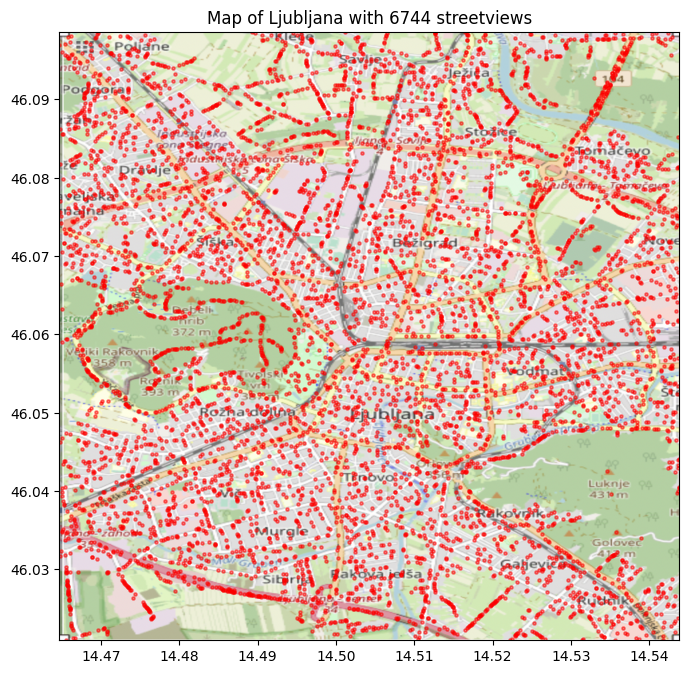

In [40]:
plot_dataset("ljubljana/labeled")

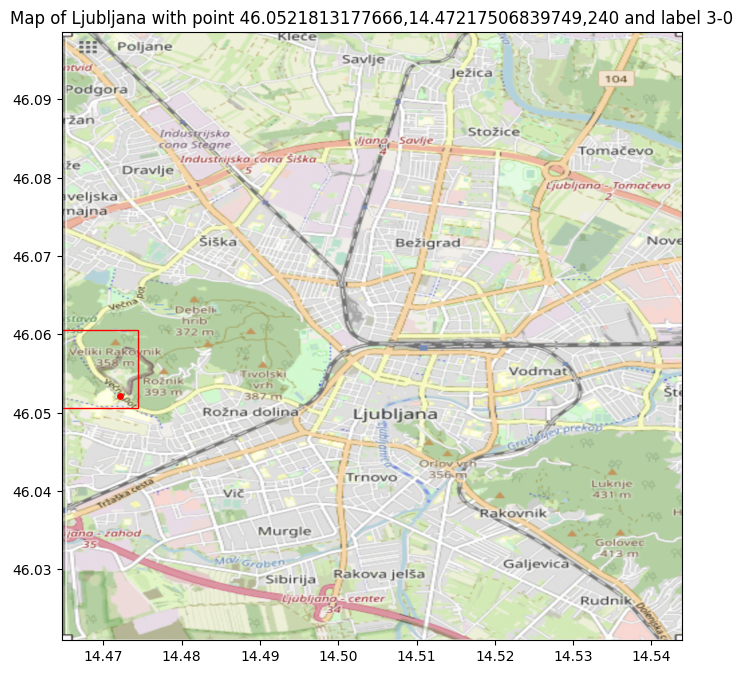

In [77]:
plot_point_and_class("46.0521813177666,14.47217506839749,240")

In [75]:
# Format dataset

import os
import shutil

N = 8
x_dif = max_loc[1] - min_loc[1]
y_dif = max_loc[0] - min_loc[0]
x_width = x_dif / N
y_width = y_dif / N

def class_mapper(label):
    coords = label.split(",")
    lat = float(coords[0])
    lng = float(coords[1])
    lat = math.floor((lat - min_loc[0]) / x_width)
    lng = math.floor((lng - min_loc[1]) / y_width)
    return f"{lat}-{lng}"

src_directory = './data/ljubljana/wrongly_labeled'
target_directory = './data/ljubljana/labeled'

for label_dir in os.listdir(src_directory):
    if label_dir[0] == ".":
        continue

    label_dir_path = os.path.join(src_directory, label_dir)

    for img in os.listdir(label_dir_path):
        if img[0] == ".":
            continue

        label = img.replace(".png", "")
    
        new_label = class_mapper(label)
        src = os.path.join(label_dir_path, img)
        dest = os.path.join(target_dir, new_label, img)
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy2(src, dest)